In [ ]:
class CointegrationResidualGenerator:
    def __init__(self, price_data: pd.DataFrame, risk_free_rate_annual: float = 0.01):
        self.price_data = price_data
        self.risk_free_rate_daily = risk_free_rate_annual / 252
        self.returns = self._compute_excess_returns(price_data)
        self.cumulative_returns = self._compute_cumulative_returns(self.returns)
        self.asset_residuals = pd.DataFrame(index=self.cumulative_returns.index)
        self.betas = {}  # Store betas for each asset

    def _compute_excess_returns(self, price_data: pd.DataFrame) -> pd.DataFrame:
        """Computes daily excess log returns."""
        log_returns = np.log(price_data / price_data.shift(1)).dropna()
        excess_returns = log_returns.subtract(self.risk_free_rate_daily)
        return excess_returns

    def _compute_cumulative_returns(self, returns: pd.DataFrame) -> pd.DataFrame:
        """Computes cumulative returns."""
        cumulative_returns = returns.cumsum()
        return cumulative_returns

    def compute_all_asset_residuals(self):
        """Computes residuals for each asset treated as dependent variable."""
        for target_asset in self.cumulative_returns.columns:
            # Set current asset as dependent variable
            y = self.cumulative_returns[target_asset].values.reshape(-1, 1)
            X = self.cumulative_returns.drop(columns=[target_asset]).values
            X_cols = self.cumulative_returns.drop(columns=[target_asset]).columns

            # Fit linear regression: y ~ X
            model = LinearRegression().fit(X, y)
            betas = model.coef_[0]
            intercept = model.intercept_[0]

            # Predict values and compute residuals for this asset
            y_pred = model.predict(X).flatten()
            residuals = y.flatten() - y_pred

            # Store residuals in DataFrame
            self.asset_residuals[target_asset] = residuals
            # Store betas for this asset
            beta_series = pd.Series(betas, index=X_cols)
            beta_series['Intercept'] = intercept
            self.betas[target_asset] = beta_series

    def get_asset_residuals(self) -> pd.DataFrame:
        """Returns residuals for all assets."""
        if self.asset_residuals.empty:
            raise ValueError("Asset residuals not yet computed.")
        return self.asset_residuals

    def get_betas_for_asset(self, asset: str) -> pd.Series:
        """Returns betas used to form residuals for a specific asset."""
        if asset not in self.betas:
            raise ValueError(f"Betas for asset '{asset}' not found. Compute residuals first.")
        return self.betas[asset]

    def prepare_cnn_input_from_residuals(self, window: int = 30):
        """
        Prepares CNN input data by creating rolling cumulative residuals.
        
        Returns:
        - 3D numpy array: [samples, window, assets]
        """
        if self.asset_residuals.empty:
            raise ValueError("Asset residuals not yet computed.")

        cnn_input_list = []

        for start_idx in range(len(self.asset_residuals) - window + 1):
            # Slice window of residuals
            window_residuals = self.asset_residuals.iloc[start_idx:start_idx + window]
            # Cumulative sum within the window
            cumulative_window = window_residuals.cumsum()
            # Store the result
            cnn_input_list.append(cumulative_window.values)

        # Convert to 3D numpy array: [samples, window, assets]
        cnn_input_array = np.array(cnn_input_list)
        return cnn_input_array


[*********************100%***********************]  2 of 2 completed


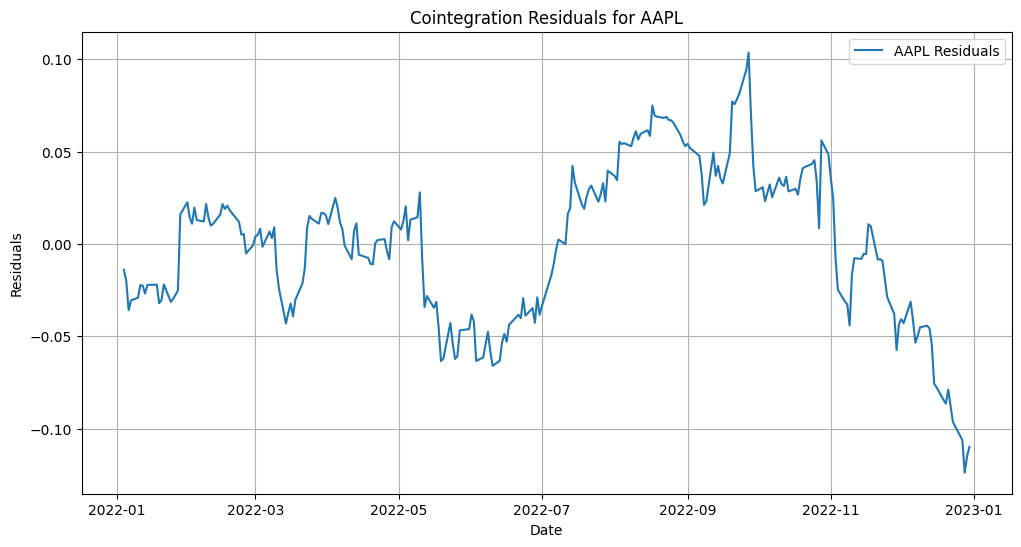

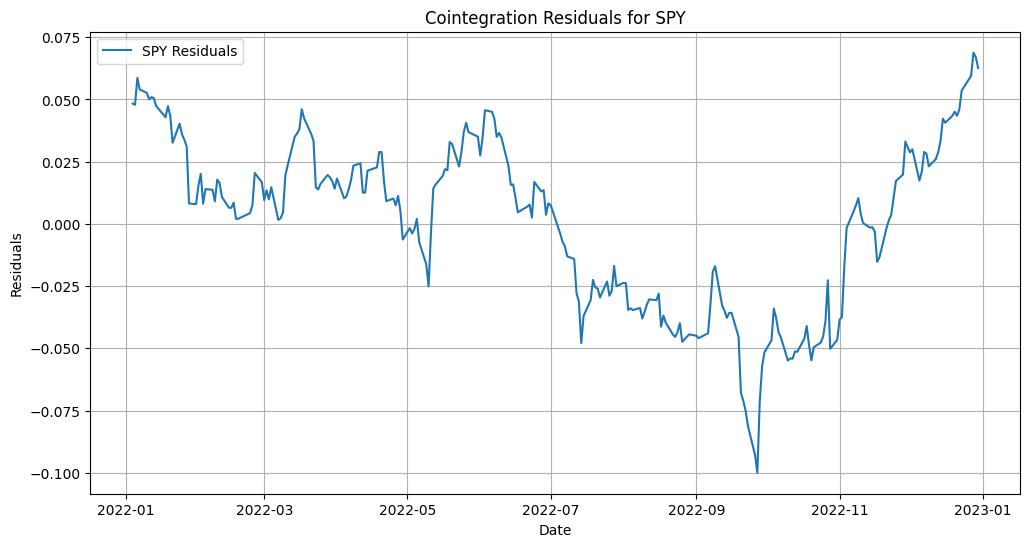

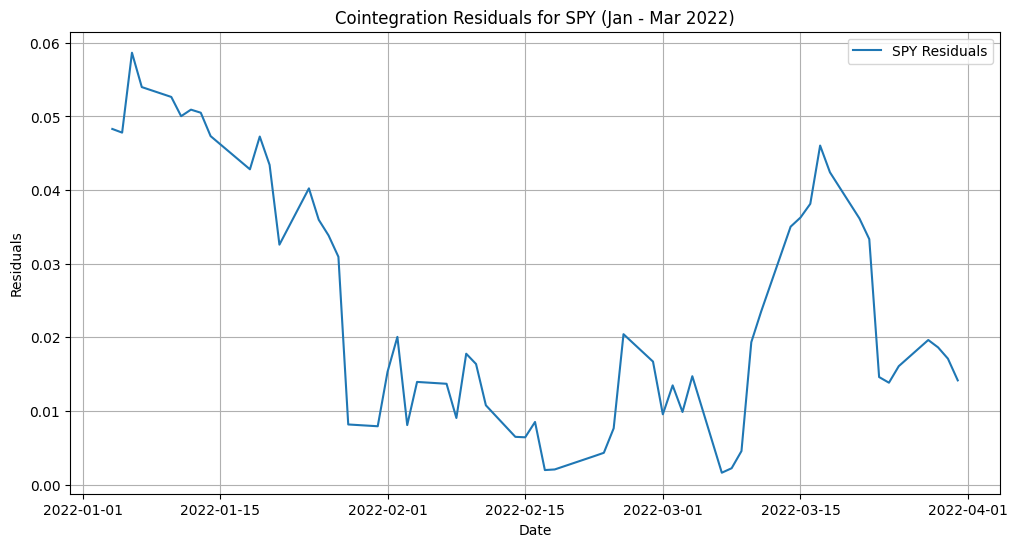

In [24]:

# Example Usage
start_date = "2022-01-01"
end_date = "2023-01-01"
tickers = ["SPY", "AAPL"]

price_data = yf.download(tickers, start=start_date, end=end_date)

# Handle cases where "Adj Close" is not present
if "Adj Close" in price_data.columns:
    price_data = price_data["Adj Close"]
elif isinstance(price_data.columns, pd.MultiIndex) and "Adj Close" in price_data.columns.get_level_values(0):
    price_data = price_data["Adj Close"]
elif "Close" in price_data.columns:
    price_data = price_data["Close"]
elif isinstance(price_data.columns, pd.MultiIndex) and "Close" in price_data.columns.get_level_values(0):
    price_data = price_data["Close"]
else:
    raise KeyError("Neither 'Adj Close' nor 'Close' columns are available in the downloaded data.")


# Initialize and compute residuals for each asset
cointegration_gen = CointegrationResidualGenerator(price_data)
cointegration_gen.compute_all_asset_residuals()

# Get residuals
asset_residuals = cointegration_gen.get_asset_residuals()

# Get the input for CNN
cnn_input = cointegration_gen.prepare_cnn_input_from_residuals(window=30)

# Plot all residuals
for asset in asset_residuals.columns:
    plt.figure(figsize=(12, 6))
    plt.plot(asset_residuals.index, asset_residuals[asset], label=f"{asset} Residuals")
    plt.title(f"Cointegration Residuals for {asset}")
    plt.xlabel("Date")
    plt.ylabel("Residuals")
    plt.legend()
    plt.grid()
    plt.show()

# # Plot every series inside the CNN input
# for i in range(cnn_input.shape[0]):
#     plt.figure(figsize=(12, 6))
#     for j in range(cnn_input.shape[2]):
#         plt.plot(cnn_input[i, :, j], label=f"Asset {j+1}")
#     plt.title(f"CNN Input Sample {i+1}")
#     plt.xlabel("Window")
#     plt.ylabel("Cumulative Residuals")
#     plt.legend()
#     plt.grid()
#     plt.show()

# Plot the cumulative residual for SPY in the first 3 months of 2022
spy_residuals = asset_residuals["SPY"].loc["2022-01-01":"2022-03-31"]
plt.figure(figsize=(12, 6))
plt.plot(spy_residuals.index, spy_residuals, label="SPY Residuals")
plt.title("Cointegration Residuals for SPY (Jan - Mar 2022)")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.legend()
plt.grid()
plt.show()

